In [1]:
!pip -q install ftfy regex tqdm
!pip -q install git+https://github.com/openai/CLIP.git
!pip -q install pytorch-metric-learning


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 33.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.9/125.9 kB 4.6 MB/s eta 0:00:00


## **Load dataset**

In [2]:
#Load data in CIFAR-10 format (Public Dataset + Training Dataset)
#https://aichallenge.hcmus.edu.vn/acm-mm-2025/entrep
!gdown 1I56vd3aWsy_nkY6zdXk4faIM6NSS5mer
!unzip -q data_cifar10_style_public.zip

Downloading...
From (original): https://drive.google.com/uc?id=1I56vd3aWsy_nkY6zdXk4faIM6NSS5mer
From (redirected): https://drive.google.com/uc?id=1I56vd3aWsy_nkY6zdXk4faIM6NSS5mer&confirm=t&uuid=088f6957-664f-4cb3-9ba8-eca501765755
To: /kaggle/working/data_cifar10_style_public.zip
100%|███████████████████████████████████████| 1.06G/1.06G [00:09<00:00, 108MB/s]


In [3]:
import os
import torch
import clip
from PIL import Image
import torch.nn.functional as F
import random
from sklearn.model_selection import train_test_split
import numpy as np

import torch.nn as nn
from pytorch_metric_learning import losses
from random import shuffle
from tqdm import tqdm
import torch.nn.init as init

from torch.optim.lr_scheduler import ReduceLROnPlateau


## **Prepare Dataset**

### 1. Embed all images using CLIP
We use the pre-trained **CLIP ViT-B/32** model to extract 512-dimensional embeddings for all images in the dataset.

---

### 2. Split embeddings into train and test sets
- For each class, if it has at least 5 images, we split it into **80% training / 20% testing** using `train_test_split`.
- For classes with very few images, all images are kept in the training set.
- The output is two dictionaries:  
  - `train_embeddings`  
  - `test_embeddings`

---

### 3. Filter class mappings (`cls_map`)
- The original `cls_map` contains mappings from `image path → class name`.
- We filter it to match only the images that remain in each split:
  - `train_cls_map`: mappings for images in `train_embeddings`.
  - `test_cls_map`: mappings for images in `test_embeddings`.

---

### 4. Filter parent-child dictionary
We previously constructed a `parent_child` dictionary where each image is mapped to a few other **most similar images in the same class** (based on cosine similarity).  
We now filter it to keep only valid parent-child pairs that exist in the train/test split.

---

### 5. Create Triplets (anchor, positive, negative)
We build triplets from the embeddings:
- **Anchor**: an image from the dataset  
- **Positive**: a highly similar image in the **same class**  
- **Negative**: a **hard negative** from a **different class**, but similar embedding (i.e., high cosine similarity)

These triplets are used to train the model with **Triplet Loss**.

---

### Summary Pipeline
Images → CLIP Embeddings → Train/Test Split → Filter cls_map → Filter parent_child → Generate Triplets → Sample Batches



In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model (ViT-B/32)
model, preprocess = clip.load("ViT-B/32", device=device)

img_dir = "./data_cifar10_style_public"
embeddings = {}

def load_images_recursively(folder):
    '''
    Embed all images in the training data and return them in a dictionary
    Return:
                embeddings = {
                    "img_name": embedding_tensor,
                    ...
                }
    '''
    embeddings = {}
    for root, dirs, files in os.walk(folder):
        for fn in files:
            if fn.lower().endswith((".png", ".jpg", ".jpeg")):
                path = os.path.join(root, fn)
                try:
                    image = preprocess(Image.open(path)).unsqueeze(0).to(device)
                    with torch.no_grad():
                        emb = model.encode_image(image)
                        emb = emb / emb.norm(dim=-1, keepdim=True)
                    rel_path = os.path.relpath(path, img_dir)
                    embeddings[rel_path] = emb.squeeze(0).cpu()
                except Exception as e:
                    print(f"Failed to load {path}: {e}")
    return embeddings

embeddings = load_images_recursively(img_dir)
print(f"Total images loaded: {len(embeddings)}")


100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 139MiB/s]


Total images loaded: 1857


In [5]:

def create_cls_map(root_dir):
    """
    Create a mapping from relative image path to its class name.

    Args:
        root_dir (str): Root directory containing class-named subfolders with images.

    Returns:
        dict: {
            "class_name/image_name.jpg": "class_name",
            ...
        }
    """
    cls_map = {}
    for cls_name in os.listdir(root_dir):
        cls_path = os.path.join(root_dir, cls_name)
        if not os.path.isdir(cls_path):
            continue
        for img_name in os.listdir(cls_path):
            if img_name.lower().endswith((".png", ".jpg", ".jpeg")):
                rel_path = f"{cls_name}/{img_name}"  # or use os.path.join and os.path.relpath for robustness
                cls_map[rel_path] = cls_name
    return cls_map
root_dir = "./data_cifar10_style_public"
cls_map = create_cls_map(root_dir)
print(f"Created cls_map for {len(cls_map)} images")


Created cls_map for 1857 images


In [6]:

def generate_parent_child(cls_map, embeddings, num_children=3):
    """
    Generate (parent, top-k children) pairs based on cosine similarity within the same class.

    Args:
        cls_map (dict): Mapping from image_name → class_name
        embeddings (dict): Mapping from image_name → embedding tensor
        num_children (int): Number of most similar children to select per parent

    Returns:
        dict: {
            'img_name_1': ['similar_img_1', 'similar_img_2', ...],
            ...
        }
    """
    # Group images by class
    class_to_imgs = {}
    for img_name, cls in cls_map.items():
        class_to_imgs.setdefault(cls, []).append(img_name)

    parent_child = {}

    for cls, img_list in class_to_imgs.items():
        for img_name in img_list:
            if img_name not in embeddings:
                continue  # Skip if embedding is missing

            anchor_emb = embeddings[img_name].unsqueeze(0)  # shape: (1, D)

            # Get other images in the same class (excluding self) that have embeddings
            others = [i for i in img_list if i != img_name and i in embeddings]
            if not others:
                continue

            other_embs = torch.stack([embeddings[i] for i in others])  # shape: (N, D)

            # Compute cosine similarity between anchor and others
            sim_scores = F.cosine_similarity(anchor_emb, other_embs)  # shape: (N,)

            # Select top-k most similar images
            topk = min(num_children, len(others))
            topk_indices = torch.topk(sim_scores, k=topk).indices

            children = [others[i] for i in topk_indices.tolist()]
            parent_child[img_name] = children

    return parent_child, class_to_imgs
parent_child, class_to_imgs = generate_parent_child(cls_map, embeddings, num_children=3)
print(f"Generated parent-child pairs for {len(parent_child)} images")


Generated parent-child pairs for 1857 images


In [8]:


# Set random seeds for reproducibility
random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Define class-wise incompatible (negative) relationships
negative_map = {
    "nose-right": ["nose-left"],
    "nose-left": ["nose-right"],
    "ear-right": ["ear-left"],
    "ear-left": ["ear-right"],
    "vc-open": ["vc-closed", "throat"],
    "vc-closed": ["vc-open"],
    "throat": ["vc-open", "vc-closed"],
}

# --- Function definitions ---

def get_most_similar_positive(anchor_name, anchor_emb, class_to_imgs, embeddings):
    """
    For a given anchor image, find the most similar image in the same class (positive).
    """
    cls = cls_map[anchor_name]
    candidates = class_to_imgs[cls]
    max_sim = -1
    pos_name = None
    anchor_emb = anchor_emb.unsqueeze(0)  # shape: [1, D]

    for candidate in candidates:
        if candidate == anchor_name:
            continue
        candidate_emb = embeddings[candidate].unsqueeze(0)
        sim = F.cosine_similarity(anchor_emb, candidate_emb).item()
        if sim > max_sim:
            max_sim = sim
            pos_name = candidate
    return pos_name


def get_hard_negative(anchor_name, anchor_emb, anchor_cls, class_to_imgs, embeddings, negative_map):
    """
    Select the hardest negative image (most similar but from a different class).
    Priority is given to predefined negative classes.
    """
    neg_classes = negative_map.get(anchor_cls, None)

    if not neg_classes:
        # Fallback: random other class
        neg_cls_candidates = [c for c in class_to_imgs.keys() if c != anchor_cls]
        if not neg_cls_candidates:
            return None
        neg_cls = random.choice(neg_cls_candidates)
        neg_imgs = class_to_imgs[neg_cls]
    else:
        neg_imgs = []
        for neg_cls in neg_classes:
            neg_imgs.extend(class_to_imgs.get(neg_cls, []))
        if not neg_imgs:
            return None

    anchor_emb = anchor_emb.unsqueeze(0)

    max_sim = -1
    hard_neg = None
    for neg_img in neg_imgs:
        if neg_img not in embeddings:
            continue
        neg_emb = embeddings[neg_img].unsqueeze(0)
        sim = F.cosine_similarity(anchor_emb, neg_emb).item()
        if sim > max_sim:
            max_sim = sim
            hard_neg = neg_img

    return hard_neg


def create_triplets(embeddings, cls_map, parent_child):
    """
    Create triplets (anchor, positive, negative) for training or testing.
    """
    triplets = []
    for anchor_name, anchor_emb in embeddings.items():
        if anchor_name not in parent_child or len(parent_child[anchor_name]) == 0:
            continue  # skip if no positive pair

        anchor_cls = cls_map[anchor_name]
        pos_name = parent_child[anchor_name][0]

        neg_name = get_hard_negative(anchor_name, anchor_emb, anchor_cls, class_to_imgs, embeddings, negative_map)
        triplets.append((
            anchor_emb,
            embeddings[pos_name],
            embeddings[neg_name],
            anchor_name,
            neg_name
        ))

    print(f"Generated {len(triplets)} triplets")
    return triplets


def filter_parent_child(parent_child_full, embeddings_subset):
    """
    Filter parent-child mapping to retain only pairs present in the current embedding subset (e.g., train/test).
    """
    parent_child_filtered = {}
    valid_imgs = set(embeddings_subset.keys())
    for parent, children in parent_child_full.items():
        if parent in valid_imgs:
            filtered_children = [c for c in children if c in valid_imgs]
            if filtered_children:
                parent_child_filtered[parent] = filtered_children
    return parent_child_filtered


def split_embeddings(embeddings, cls_map, test_size=0.2, min_images=5):
    """
    Split embeddings and cls_map into train/test sets, stratified by class.
    Classes with too few samples go entirely to the training set.
    """
    train_embeds = {}
    test_embeds = {}
    for cls in set(cls_map.values()):
        imgs = [img for img in cls_map if cls_map[img] == cls and img in embeddings]
        if len(imgs) < min_images:
            for img in imgs:
                train_embeds[img] = embeddings[img]
            continue
        train_imgs, test_imgs = train_test_split(imgs, test_size=test_size, random_state=42)
        for img in train_imgs:
            train_embeds[img] = embeddings[img]
        for img in test_imgs:
            test_embeds[img] = embeddings[img]
    return train_embeds, test_embeds


def filter_cls_map(embeddings_subset, cls_map):
    """
    Filter cls_map to retain only images that are present in the given embeddings subset.
    """
    return {k: v for k, v in cls_map.items() if k in embeddings_subset}


def get_triplet_batch(triplets, batch_size=32):
    """
    Sample a batch of triplets (anchor, positive, negative).
    """
    if len(triplets) < batch_size:
        return None
    selected = random.sample(triplets, batch_size)
    anchor = torch.stack([t[0] for t in selected])
    positive = torch.stack([t[1] for t in selected])
    negative = torch.stack([t[2] for t in selected])
    return anchor, positive, negative



# Step 1: Split the embeddings into training and test sets
train_embeddings, test_embeddings = split_embeddings(embeddings, cls_map)

# Step 2: Filter the class mappings
train_cls_map = filter_cls_map(train_embeddings, cls_map)
test_cls_map = filter_cls_map(test_embeddings, cls_map)

# Step 3: Filter the parent-child structure for both train and test
parent_child_train = filter_parent_child(parent_child, train_embeddings)
parent_child_test = filter_parent_child(parent_child, test_embeddings)

# Step 4: Create triplets for train and test
train_triplets = create_triplets(train_embeddings, train_cls_map, parent_child=parent_child_train)
test_triplets = create_triplets(test_embeddings, test_cls_map, parent_child=parent_child_test)

# Step 5: Sample a batch to check shapes
anchor, positive, negative = get_triplet_batch(train_triplets, batch_size=32)
print(anchor.shape, positive.shape, negative.shape)


Generated 1464 triplets
Generated 181 triplets
torch.Size([32, 512]) torch.Size([32, 512]) torch.Size([32, 512])


In [21]:
from collections import Counter

def print_class_distribution(cls_map):
    counter = Counter(cls_map.values())
    for cls, count in counter.items():
        print(f"Class {cls}: {count} images")

print("Train class distribution:")
print_class_distribution(filter_cls_map(train_embeddings, cls_map))

print("\nTest class distribution:")
print_class_distribution(filter_cls_map(test_embeddings, cls_map))


Train class distribution:
Class nose-left: 376 images
Class throat: 86 images
Class vc-open: 191 images
Class nose-right: 362 images
Class ear-right: 160 images
Class vc-closed: 167 images
Class ear-left: 142 images

Test class distribution:
Class nose-left: 94 images
Class throat: 22 images
Class vc-open: 48 images
Class nose-right: 91 images
Class ear-right: 40 images
Class vc-closed: 42 images
Class ear-left: 36 images


## **Visualize triplets**

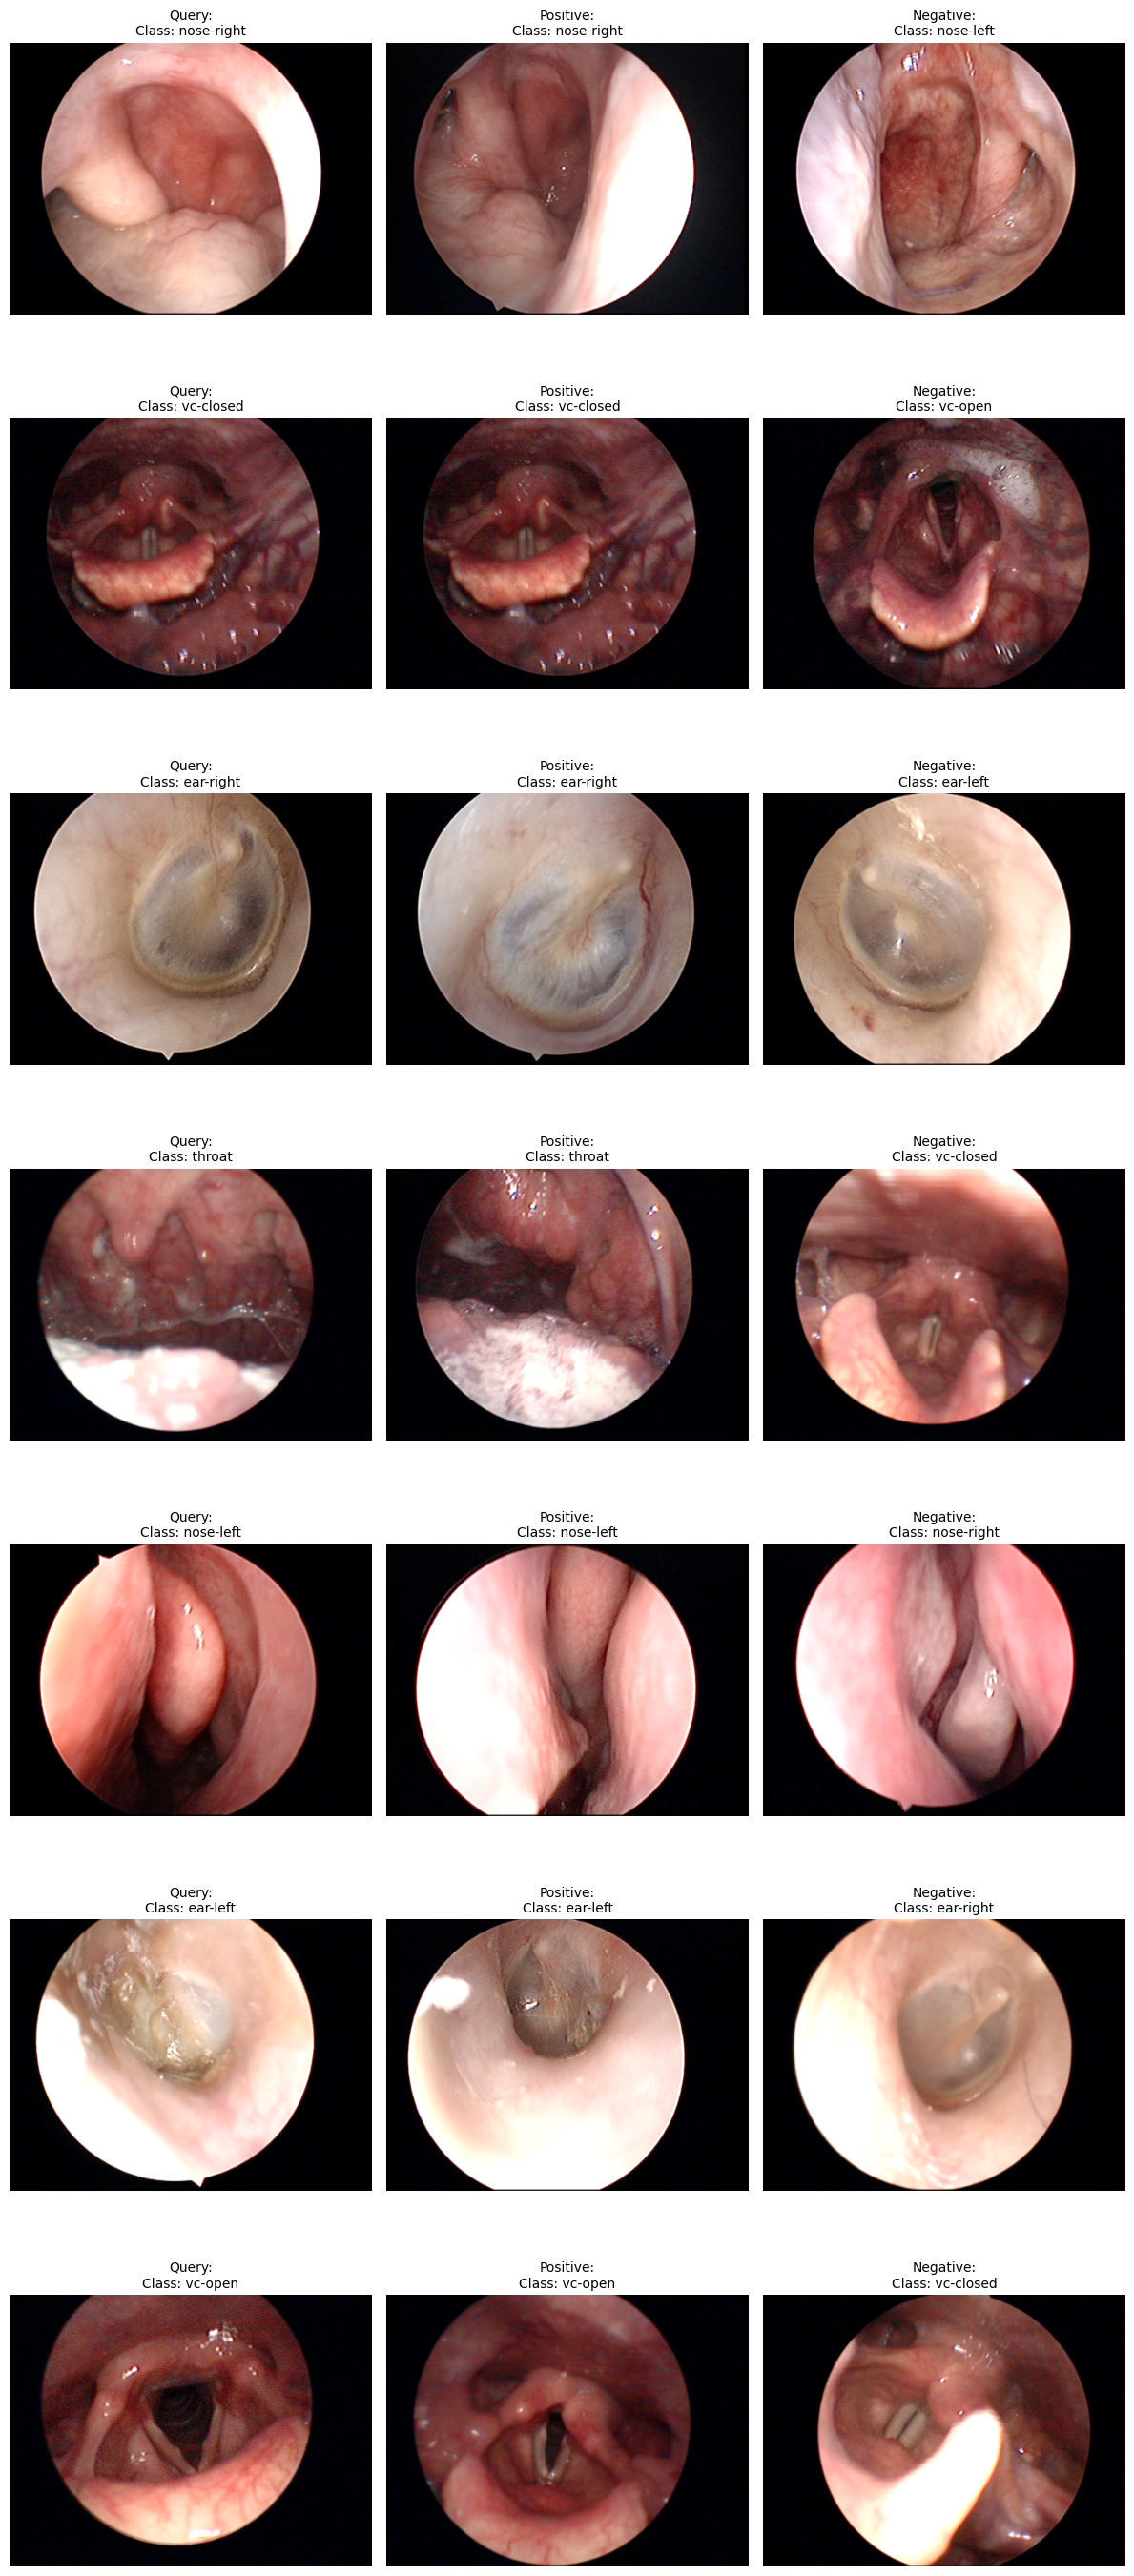

In [15]:
import matplotlib.pyplot as plt
from PIL import Image
import os

def visualize_triplets_unique_query_classes(triplets, cls_map, image_dir, num_samples=7):
    """
    Visualize triplets (query, positive, negative) with unique query classes.

    Args:
        triplets (list): Each element is (anchor_emb, pos_emb, neg_emb, anchor_name, neg_name)
        cls_map (dict): image_name → class_name
        image_dir (str): Path to directory containing images
        num_samples (int): Number of triplets to display
    """
    seen_classes = set()
    count = 0
    plt.figure(figsize=(12, 4 * num_samples))

    for triplet in triplets:
        if count >= num_samples:
            break

        anchor_emb, pos_emb, neg_emb, anchor_name, neg_name = triplet

        # Skip if query class has already been visualized
        query_class = cls_map.get(anchor_name)
        if query_class in seen_classes:
            continue

        # Identify pos_name (you can also store pos_name directly in triplet to avoid this lookup)
        pos_name = None
        for name, emb in embeddings.items():
            if torch.equal(emb, pos_emb):
                pos_name = name
                break
        if pos_name is None:
            continue

        # Load images
        try:
            anchor_img = Image.open(os.path.join(image_dir, anchor_name)).convert("RGB")
            pos_img = Image.open(os.path.join(image_dir, pos_name)).convert("RGB")
            neg_img = Image.open(os.path.join(image_dir, neg_name)).convert("RGB")
        except:
            continue

        # Plot
        for j, (img, title) in enumerate(zip(
            [anchor_img, pos_img, neg_img],
            [
                f"Query:\nClass: {cls_map[anchor_name]}",
                f"Positive:\nClass: {cls_map[pos_name]}",
                f"Negative:\nClass: {cls_map[neg_name]}"
            ]
        )):
            plt.subplot(num_samples, 3, count * 3 + j + 1)
            plt.imshow(img)
            plt.title(title, fontsize=10)
            plt.axis("off")

        seen_classes.add(query_class)
        count += 1

    if count == 0:
        print("⚠️ Không tìm thấy đủ triplet với query khác class!")
    else:
        plt.tight_layout()
        plt.show()

# Gọi hàm
visualize_triplets_unique_query_classes(train_triplets, cls_map, image_dir="./data_cifar10_style_public", num_samples=7)


## **Training**

We implement a lightweight **Vector Field** module inspired by *Flow Matching* techniques. The goal is to learn a **time-dependent vector field** that maps an input embedding `x` to a flow direction `dx/dt` at time `t`.

This module is integrated with an **Euler solver** to simulate the flow of embeddings across time steps (used before applying triplet loss).

---

### **1. Time Encoding via Gaussian Fourier Projection**

We map the scalar time `t` into a higher-dimensional periodic space using sinusoidal features:

```
Fourier(t) = [sin(tW), cos(tW)]
```

- `W` is a fixed random projection matrix (not learnable).
- Output shape: `[B, D]` where `D = t_dim`.

---

### **2. Input Normalization**

- Input embedding `x` (dim = 512) is normalized using `LayerNorm`.
- The normalized `x` is concatenated with the encoded time vector:  
  → `input = [LayerNorm(x), Fourier(t)]`  
  → Final input shape: `[B, 512 + t_dim]`

---

### **3. Multi-Head MLPs**

- We use `n_heads = 4` independent MLPs.
- Each MLP structure:  
  ```
  Linear → LayerNorm → SiLU → Dropout → Linear
  ```
- The output of all MLP heads are **averaged** to produce the vector field direction.

---

### **4. Residual Connection**

- The final output is:
  ```
  output = mean_over_heads(MLP(x, t)) + w * x
  ```
- `w` is a **learnable residual weight**.
- This residual connection helps stabilize training and preserves the input structure.

---
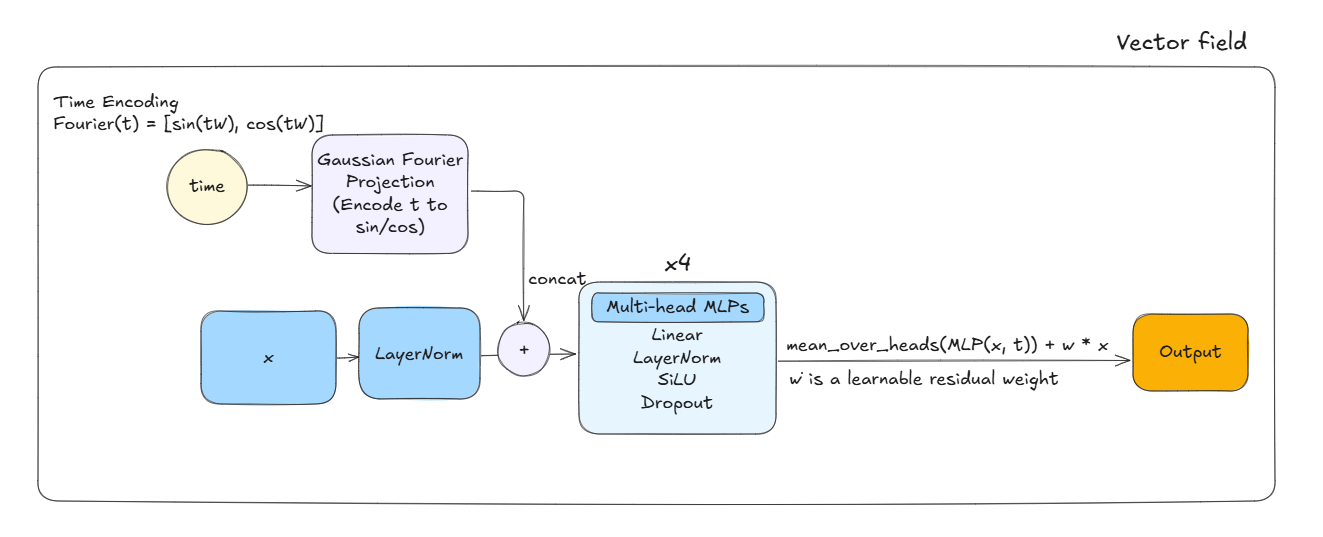

In [23]:
embed_dim = 512
class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, scale=10.0):
        super().__init__()
        # Fixed random weights for projecting scalar t to higher frequency space
        self.W = nn.Parameter(torch.randn(1, embed_dim // 2) * scale, requires_grad=False)

    def forward(self, t):
        # Ensure t has shape [B, 1]
        if t.ndim == 1:
            t = t.unsqueeze(-1)
        proj = t * self.W  # Shape: [B, D/2]
        # Return sinusoidal and cosinusoidal projection: [sin(tW), cos(tW)] → Shape: [B, D]
        return torch.cat([torch.sin(proj), torch.cos(proj)], dim=-1)

class VectorField(nn.Module):
    def __init__(self, dim, t_dim=32, hidden_dim=256, n_heads=4, dropout_prob=0.1):
        super().__init__()
        self.x_norm = nn.LayerNorm(dim)  # Normalize input embeddings
        self.time_encoder = GaussianFourierProjection(t_dim)  # Time embedding module
        self.dropout = nn.Dropout(dropout_prob)

        # Create multiple independent heads (like a lightweight transformer block)
        self.heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(dim + t_dim, hidden_dim),     # Project input + time
                nn.LayerNorm(hidden_dim),
                nn.SiLU(),                               # Activation: SiLU 
                nn.Dropout(dropout_prob),
                nn.Linear(hidden_dim, dim)              # Back to original embedding dimension
            ) for _ in range(n_heads)
        ])

        self.res_weight = nn.Parameter(torch.tensor(1.0))  # Learnable residual scaling
        self.out_norm = nn.LayerNorm(dim)  # Final normalization (not applied directly here)
        self.initialize_weights()

    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                # Use Kaiming initialization (good for ReLU/SiLU)
                init.kaiming_uniform_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    init.zeros_(m.bias)


    def forward(self, x, t):
        # Handle scalar or 1D tensor time input → ensure shape [B, 1]
        if not isinstance(t, torch.Tensor):
            t = torch.full((x.shape[0], 1), t, device=x.device)
        elif t.ndim == 0:
            t = t.expand(x.shape[0], 1)
        elif t.ndim == 1:
            t = t.unsqueeze(-1)

        x_normed = self.x_norm(x)                     # Normalize input
        t_encoded = self.time_encoder(t.to(x.device)) # Encode time t
        inp = torch.cat([x_normed, t_encoded], dim=-1)  # Concatenate along feature dim

        # Pass through each head and average their outputs
        head_outs = [head(inp) for head in self.heads]
        out = torch.mean(torch.stack(head_outs), dim=0)

        # Add residual connection scaled by learnable weight
        return out + self.res_weight * x




In each Euler step, the function `vf(x, t)` (i.e., `VectorField.forward(x, t)`) is called. The time value `t` is passed into the `GaussianFourierProjection` module to encode it into a sinusoidal vector: `[sin(tW), cos(tW)]`. This time encoding is concatenated with the normalized input embedding (`x_normed`) to form the combined input `[x_normed, t_encoded]`. This input is then passed through multiple MLP heads. The result is an update vector `Δx`, which is used to move the embedding forward in the Euler integration process.


In [24]:
def euler_integration(x0, vf, steps=10):
    """
    Args:
        x0: initial embeddings [B, D]
        vf: vector field model (takes in x and t, returns dx/dt)
        steps: number of integration steps
    Returns:
        Transformed embeddings x(T)
    """
    dt = 1.0 / steps
    x = x0
    for i in range(steps):
        t = i * dt
        k1 = vf(x, t)
        k2 = vf(x + 0.5 * dt * k1, t + 0.5 * dt)
        k3 = vf(x + 0.5 * dt * k2, t + 0.5 * dt)
        k4 = vf(x + dt * k3, t + dt)
        x = x + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
    return x

    #return correct / total if total > 0 else 0.0
def compute_triplet_loss(model, triplets, loss_func, steps=10):
    """
       Compute loss using MultiSimilarityLoss
       It takes transformed embeddings + integer labels
   
    """
    model.eval()
    total_loss = 0.0
    num_batches = 0

    with torch.no_grad():
        for i in range(0, len(triplets), 64):
            batch = triplets[i : i + 64]
            if len(batch) == 0:
                continue

            batch_embeddings, batch_labels = get_embeddings_labels_from_triplets(batch, test_cls_map, class2idx)
            if batch_embeddings is None or len(batch_embeddings) == 0:
                continue

            batch_embeddings = batch_embeddings.to(device).float()
            batch_labels = batch_labels.to(device).long()

            pred_embeddings = euler_integration(batch_embeddings, model, steps=steps)
            loss = loss_func(pred_embeddings, batch_labels)

            total_loss += loss.item()
            num_batches += 1

    return total_loss / max(1, num_batches)

def get_embeddings_labels_from_triplets(triplets_batch, cls_map, class2idx):
    '''
        Convert list of triplets into tensors for model input.
    '''
    embeddings = []
    labels = []

    for anchor_emb, positive_emb, negative_emb, anchor_name, negative_name in triplets_batch:
        anchor_cls = cls_map[anchor_name]
        negative_cls = cls_map[negative_name]

        embeddings.extend([anchor_emb, positive_emb, negative_emb])
        labels.extend([
            class2idx[anchor_cls],
            class2idx[anchor_cls],
            class2idx[negative_cls]
        ])

    embeddings_tensor = torch.stack(embeddings)
    labels_tensor = torch.tensor(labels)
    return embeddings_tensor, labels_tensor



In [ ]:
#Define label mapping
class2idx = {'ear-left': 3,
 'ear-right': 2,
 'nose-left': 1,
 'nose-right': 0,
 'throat': 6,
 'vc-closed': 4,
 'vc-open': 5}
# Initialize model, loss, optimizer, scheduler
vf = VectorField(embed_dim).to(device).float()
optimizer = torch.optim.AdamW(vf.parameters(), lr=1e-4)
loss_func = losses.MultiSimilarityLoss()

# Hyperparameters cho scheduler và early stopping
warmup_epochs = 20
early_stop_patience = 40
scheduler_patience = 15
scheduler_factor = 0.8
best_loss = float('inf')
epochs_no_improve = 0

#LR Scheduler & Early Stopping
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=scheduler_factor, patience=scheduler_patience)

epochs = 200
batch_size = 32


best_test_loss = float('inf')
best_train_loss = float('inf')
epochs_no_improve = 0
delta = 5e-4  # min change in loss to count as improvement

#Training Loop
for epoch in tqdm(range(epochs)):
    vf.train()
    epoch_loss = 0.0
    num_batches = 0
    shuffle(train_triplets)
    # --- Iterate over triplet batches ---
    for i in range(0, len(train_triplets), batch_size):
        batch = train_triplets[i: i + batch_size]
        if not batch:
            continue

        optimizer.zero_grad()
        # Prepare batch embeddings and labels
        batch_embeddings, batch_labels = get_embeddings_labels_from_triplets(batch, train_cls_map, class2idx)

        if batch_embeddings is None or len(batch_embeddings) == 0:
            continue

        batch_embeddings = batch_embeddings.to(device).float()
        batch_labels = batch_labels.to(device).long()
         # Apply vector field transformation
        pred_embeddings = euler_integration(batch_embeddings, vf, steps=10)
        loss = loss_func(pred_embeddings, batch_labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(vf.parameters(), max_norm=5.0)
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1


    #Compute test loss after each epoch 
    vf.eval()
    test_loss = compute_triplet_loss(vf, test_triplets, loss_func, steps=10)

    avg_loss = epoch_loss / max(1, num_batches)  

    # LR Warmup and Scheduler
    old_lr = optimizer.param_groups[0]['lr']
    if epoch >= warmup_epochs:
        scheduler.step(test_loss)
    else:
        scheduler.step(float('inf'))

    new_lr = optimizer.param_groups[0]['lr']
    if new_lr < old_lr:
        print(f"LR reduced at epoch {epoch + 1} → {new_lr:.1e}")

    #Early stopping kết hợp test và train loss
    if (test_loss < best_test_loss - delta) or (avg_loss < best_train_loss - delta):
        # If the test loss or train loss improves significantly, then reset the epochs_no_improve counter
        best_test_loss = min(test_loss, best_test_loss)
        best_train_loss = min(avg_loss, best_train_loss)
        epochs_no_improve = 0
        torch.save(vf.state_dict(), "best_vf.pt")
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stop_patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break

In [ ]:
#save final model
torch.save(vf.state_dict(), "vf_model.pth")
